<a href="https://colab.research.google.com/github/CamiSilvae/PDI/blob/main/ClaseOrdinaria/ExamenOrd/Ejercicio2/ORD_EJ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXAMEN ORDINARIO

Camila Andrea Silva Espinoza (2109522)

---

**EJERCICIO 2: Segmentación combinada de alto nivel**

1. Carga de librerias y de imagen

En esta celda importamos las librerías necesarias y subimos la imagen usando files.upload(). Convertimos la imagen a escala de grises y la normalizamos a rango [0,1]. Además, mostramos la imagen original para verificar que se cargó correctamente. Si la imagen es muy grande, recomiendo redimensionarla aquí para agilizar el procesamiento

Saving Ejercicio2.jpg to Ejercicio2.jpg


(np.float64(-0.5), np.float64(479.5), np.float64(269.5), np.float64(-0.5))

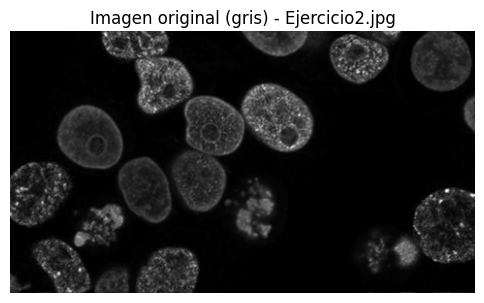

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab import files
import skimage
from skimage import filters, morphology, measure, feature, segmentation, util
from scipy import ndimage as ndi
import pandas as pd

uploaded = files.upload()
image_name = list(uploaded.keys())[0]

img_color = cv2.imread(image_name, cv2.IMREAD_COLOR)
if img_color is None:
    raise ValueError("No fue posible leer la imagen. Revisa el archivo.")
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
img = img_gray.astype(np.float32) / 255.0

plt.figure(figsize=(6,6))
plt.title(f"Imagen original (gris) - {image_name}")
plt.imshow(img, cmap='gray')
plt.axis('off')


2. Suavizado con Gaussiano σ= 2

Aplicaremos un suavizado Gaussiano con sigma = 2 para reducir ruido de alta frecuencia y evitar detecciones espurias en etapas posteriores (Otsu, Canny, Watershed). Mostramos la imagen suavizada.

(np.float64(-0.5), np.float64(479.5), np.float64(269.5), np.float64(-0.5))

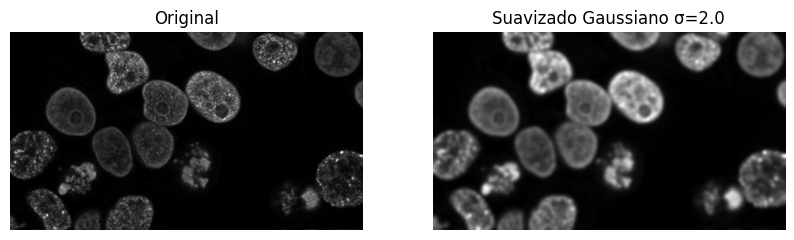

In [2]:
sigma = 2.0

ksize = int(6*sigma + 1)
if ksize % 2 == 0:
    ksize += 1

img_smooth = cv2.GaussianBlur((img*255).astype(np.uint8), (ksize, ksize), sigmaX=sigma, sigmaY=sigma)
img_smooth = img_smooth.astype(np.float32) / 255.0

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title(f"Suavizado Gaussiano σ={sigma}"); plt.imshow(img_smooth, cmap='gray'); plt.axis('off')


3. Obtención máscara con Otsu

Se aplica el método de Otsu para obtener una máscara binaria automática. Otsu determina un umbral global que maximiza la separación entre clases en el histograma. Después aplicamos un poco de morfología (apertura) para eliminar pequeños artefactos.

(np.float64(-0.5), np.float64(479.5), np.float64(269.5), np.float64(-0.5))

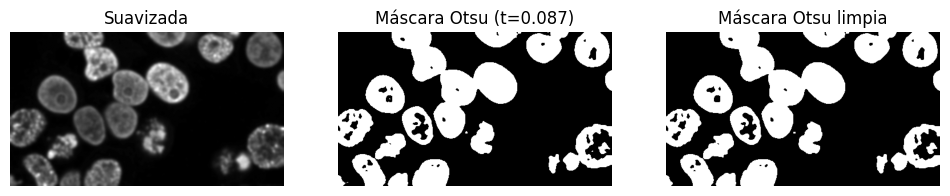

In [3]:
otsu_thresh = filters.threshold_otsu(img_smooth)
mask_otsu = (img_smooth >= otsu_thresh).astype(np.uint8)

kernel = np.ones((3,3), dtype=np.uint8)
mask_otsu_clean = cv2.morphologyEx(mask_otsu, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Suavizada"); plt.imshow(img_smooth, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title(f"Máscara Otsu (t={otsu_thresh:.3f})"); plt.imshow(mask_otsu, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Máscara Otsu limpia"); plt.imshow(mask_otsu_clean, cmap='gray'); plt.axis('off')


4. Extracción de bordes con Canny multiescala (σ = 1, 2, 4)

Se extraen los bordes aplicando Canny con tres niveles de suavizado (σ = 1, 2 y 4). Combinaremos los resultados (unión) para obtener un mapa de bordes multiescala que capture tanto bordes finos como gruesos. Ajustamos umbrales por medio de percentiles adaptativos de la magnitud del gradiente.

(np.float64(-0.5), np.float64(479.5), np.float64(269.5), np.float64(-0.5))

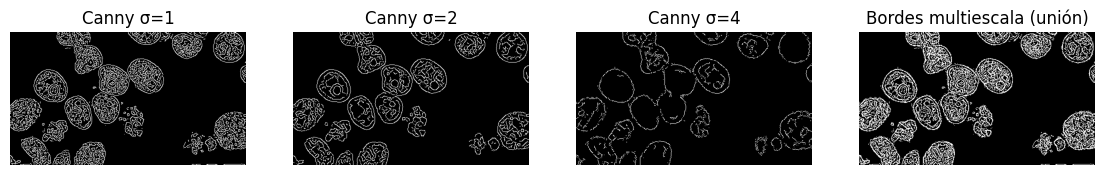

In [4]:
sigmas = [1, 2, 4]
edges_scales = []

gradx = cv2.Sobel((img_smooth*255).astype(np.uint8), cv2.CV_64F, 1, 0, ksize=3)
grady = cv2.Sobel((img_smooth*255).astype(np.uint8), cv2.CV_64F, 0, 1, ksize=3)
grad_mag = np.sqrt(gradx**2 + grady**2)

low_pct = 30
high_pct = 70
low_thresh = np.percentile(grad_mag, low_pct)
high_thresh = np.percentile(grad_mag, high_pct)

for s in sigmas:
    k = int(6*s + 1)
    if k % 2 == 0:
        k += 1
    img_blur = cv2.GaussianBlur((img*255).astype(np.uint8), (k,k), sigmaX=s)
    edges = cv2.Canny(img_blur, threshold1=low_thresh, threshold2=high_thresh)
    edges_scales.append(edges.astype(np.uint8))

edges_multiscale = np.zeros_like(edges_scales[0])
for e in edges_scales:
    edges_multiscale = cv2.bitwise_or(edges_multiscale, e)

plt.figure(figsize=(14,4))
for i, s in enumerate(sigmas):
    plt.subplot(1, len(sigmas)+1, i+1)
    plt.title(f"Canny σ={s}")
    plt.imshow(edges_scales[i], cmap='gray')
    plt.axis('off')
plt.subplot(1, len(sigmas)+1, len(sigmas)+1)
plt.title("Bordes multiescala (unión)")
plt.imshow(edges_multiscale, cmap='gray')
plt.axis('off')


5. Generación de marcadores externos con regiones de Watershed

Utilizando la transformada de distancia sobre la máscara binaria (Otsu). Los máximos locales sobre la distancia indicarán centros de objetos (posibles células). Etiquetamos estos máximos para crear marcadores y aplicamos Watershed sobre el gradiente de la imagen suavizada para segmentar objetos.

(np.float64(-0.5), np.float64(479.5), np.float64(269.5), np.float64(-0.5))

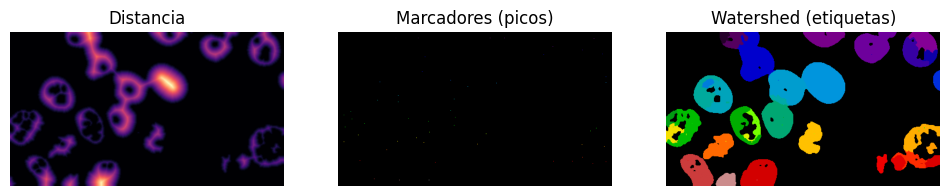

In [5]:
distance = ndi.distance_transform_edt(mask_otsu_clean)

from skimage.feature import peak_local_max

min_distance = 10
coords = peak_local_max(distance, labels=mask_otsu_clean, min_distance=min_distance)
markers = np.zeros_like(distance, dtype=np.int32)
for i, (r, c) in enumerate(coords, start=1):
    markers[r, c] = i

if markers.max() == 0:
    markers, _ = ndi.label(mask_otsu_clean)

markers_labeled, _ = ndi.label(markers > 0)

grad_norm = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min() + 1e-12)
labels_ws = segmentation.watershed(grad_norm, markers_labeled, mask=mask_otsu_clean)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Distancia"); plt.imshow(distance, cmap='magma'); plt.axis('off')
plt.subplot(1,3,2); plt.title("Marcadores (picos)"); plt.imshow(markers_labeled, cmap='nipy_spectral'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Watershed (etiquetas)"); plt.imshow(labels_ws, cmap='nipy_spectral'); plt.axis('off')


6. Fusión usando cierre + apertura

Después de obtener la segmentación inicial con Watershed, aplicaremos operaciones morfológicas de cierre seguido de apertura para fusionar regiones cercanas y eliminar pequeñas imperfecciones. Esto ayuda a unir fragmentos y reducir sobresegmentación leve.

(np.float64(-0.5), np.float64(479.5), np.float64(269.5), np.float64(-0.5))

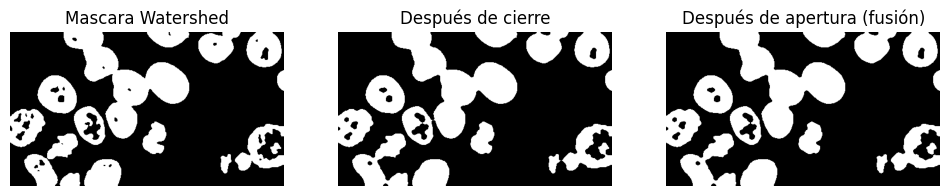

In [6]:
mask_ws = (labels_ws > 0).astype(np.uint8)

kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

mask_closed = cv2.morphologyEx(mask_ws, cv2.MORPH_CLOSE, kernel_close, iterations=1)
mask_fused = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel_open, iterations=1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Mascara Watershed"); plt.imshow(mask_ws, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("Después de cierre"); plt.imshow(mask_closed, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Después de apertura (fusión)"); plt.imshow(mask_fused, cmap='gray'); plt.axis('off')


7. Cuenta células y cálculo de área y perímetro

Se etiquetaron las regiones resultantes y calculamos áreas (número de píxeles) y perímetros (usando regionprops o contornos de OpenCV). Presentamos una tabla con el conteo y estadísticas básicas (media, mediana, etc.).

In [14]:
labels_final = measure.label(mask_fused, connectivity=2)
props = measure.regionprops(labels_final)

areas = []
perimeters = []
centroids = []
for p in props:
    areas.append(p.area)
    perimeters.append(p.perimeter)
    centroids.append(p.centroid)

df_regions = pd.DataFrame({
    'Etiqueta': np.arange(1, len(props)+1),
    'Área': areas,
    'Perimetro': perimeters,
    'Centroide Fila': [c[0] for c in centroids],
    'Centroide Columna': [c[1] for c in centroids]
})
df_stats = df_regions.describe().loc[['count','mean','50%','std','min','max']]
print(f"Cantidad de regiones detectadas: {len(props)}")
df_regions.head(10)


Cantidad de regiones detectadas: 14


,Etiqueta,Área,Perimetro,Centroide Fila,Centroide Columna
0,1,14844.0,848.908730,85.998989,204.881366
1,2,1446.0,173.396970,10.461272,277.112725
2,3,2751.0,229.480231,24.371501,362.156670
3,4,2920.0,264.793939,29.501027,444.648630
4,5,337.0,82.041631,84.157270,474.332344
5,6,3307.0,304.977705,109.687632,82.555186
6,7,2047.0,368.232539,162.170493,138.386419
7,8,2841.0,351.847763,165.446322,27.356565
8,9,1606.0,175.095454,187.000623,253.632005
9,10,3235.0,435.989899,206.157651,436.987635


8. Visualizaciones (perimetría morfológica, regiones MSER y contronos finales)

Se muestra:
* Perimetría morfológica (dilatación − erosión) para resaltar bordes gruesos.

* Regiones MSER detectadas (usando OpenCV MSER), mostrando rectángulos o máscaras.

* Contornos finales superpuestos sobre la imagen original para presentar el resultado final.

(np.float64(-0.5), np.float64(479.5), np.float64(269.5), np.float64(-0.5))

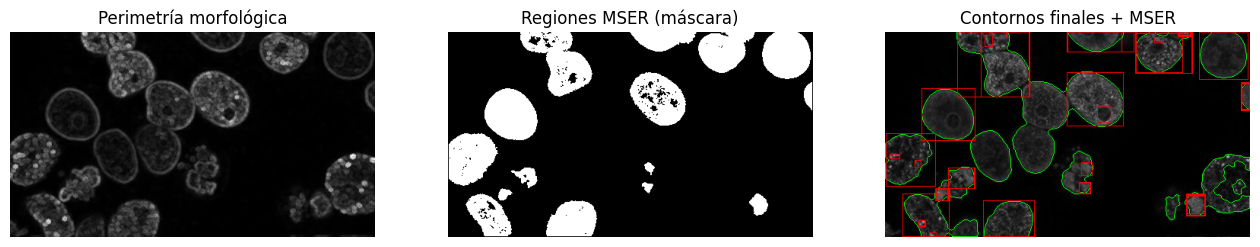

In [11]:
img_u8 = (img*255).astype(np.uint8)
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
dil = cv2.dilate(img_u8, kernel_grad)
ero = cv2.erode(img_u8, kernel_grad)
morph_gradient = cv2.subtract(dil, ero)

mser = cv2.MSER_create()
mser.setMinArea(30)
mser.setMaxArea(10000)

regions, bboxes = mser.detectRegions((img*255).astype(np.uint8))

mser_mask = np.zeros_like(img_u8, dtype=np.uint8)
for i, reg in enumerate(regions):
    for (x,y) in reg:
        if 0 <= y < mser_mask.shape[0] and 0 <= x < mser_mask.shape[1]:
            mser_mask[y,x] = 255

contours, hierarchy = cv2.findContours((mask_fused*255).astype(np.uint8),
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(16,6))

plt.subplot(1,3,1)
plt.title("Perimetría morfológica")
plt.imshow(morph_gradient, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Regiones MSER (máscara)")
plt.imshow(mser_mask, cmap='gray')
plt.axis('off')

img_overlay = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_overlay, contours, -1, (0,255,0), 1)

for (x,y,w,h) in bboxes:
    cv2.rectangle(img_overlay, (x,y), (x+w, y+h), (0,0,255), 1)

plt.subplot(1,3,3)
plt.title("Contornos finales + MSER")
plt.imshow(cv2.cvtColor(img_overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')


9. Análisis final

Resumen con número total de células detectadas, estadísticas de áreas y perímetros, y un CSV de resultados.

In [13]:
n_regions = len(props)
areas_arr = np.array(areas)
perimeters_arr = np.array(perimeters)

summary = {
    'Numero de regiones': n_regions,
    'Promedio del Área': float(np.mean(areas_arr)) if n_regions>0 else 0.0,
    'Mediana del área': float(np.median(areas_arr)) if n_regions>0 else 0.0,
    'Promedio del permietro': float(np.mean(perimeters_arr)) if n_regions>0 else 0.0
}

print("Resumen de resultados:")
for k,v in summary.items():
    print(f" - {k}: {v}")

csv_name = "regions_summary.csv"
df_regions.to_csv(csv_name, index=False)
print(f"\nTabla de regiones: {csv_name} (con resultados)")


Resumen de resultados:
 - Numero de regiones: 14
 - Promedio del Área: 3063.6428571428573
 - Mediana del área: 2630.5
 - Promedio del permietro: 291.1309264388822

Tabla de regiones: regions_summary.csv (con resultados)
